In [147]:
import subprocess
import struct
import json
import sys
import time

exe = "D:/dev/workspaces/CPotree/master/x64/Release/CPotree.exe"

file = "D:/dev/pointclouds/converted/CA13/cloud.js"
coordinates = "{693550.968, 3915914.169},{693890.618, 3916387.819},{694584.820, 3916458.180},{694786.239, 3916307.199}"
width = "14.0"
minLevel = "0"
maxLevel = "5"

start = time.time()
p = subprocess.Popen([exe, file, coordinates, width, minLevel, maxLevel], bufsize=-1, stdout=subprocess.PIPE)
[out, err] = p.communicate()
end = time.time()
print("duration", end - start)

headerSize = struct.unpack('i', out[0:4])[0];
header = out[4:4+headerSize].decode("ascii")
buffer = out[4+headerSize:]

print(header)

duration 0.12700557708740234
{
	"points": 38772,
	"boundingBox": {
		"lx": 693546.239375,
		"ly": 3915910.309250,
		"lz": -0.290000,
		"ux": 694789.848125,
		"uy": 3916464.649125,
		"uz": 171.229375
	},
	"pointAttributes": [
		"POSITION_CARTESIAN",
		"RGB"
	],
	"x": 103900,
	"y": 139760,
	"z": 139060,
	"bytesPerPoint": 15,
	"scale": 0.001000
}



In [148]:
jHeader = json.loads(header)

numPoints = int(jHeader["points"])
scale = float(jHeader["scale"])
bytesPerPoint = int(jHeader["bytesPerPoint"])
attributes = jHeader["pointAttributes"]

lx = []
ly = []
lz = []
lc = []

for i in range(numPoints):
    byteOffset = bytesPerPoint * i
    pbuffer = buffer[byteOffset:byteOffset + bytesPerPoint]
    
    
    aoffset = 0
    for attribute in attributes:
        
        if attribute == "POSITION_CARTESIAN":
            ux = struct.unpack('i', pbuffer[aoffset + 0: aoffset + 4])[0]
            uy = struct.unpack('i', pbuffer[aoffset + 4: aoffset + 8])[0]
            uz = struct.unpack('i', pbuffer[aoffset + 8: aoffset + 12])[0]
            
            x = ux * scale
            y = uy * scale
            z = uz * scale
            
            lx.append(x)
            ly.append(y)
            lz.append(z)
            
            aoffset = aoffset + 12
        elif attribute == "RGB":
            r = pbuffer[aoffset] / 255
            g = pbuffer[13] / 255
            b = pbuffer[14] / 255
            
            lc.append([r, g, b, 1.0])
            
            aoffset = aoffset + 3
            


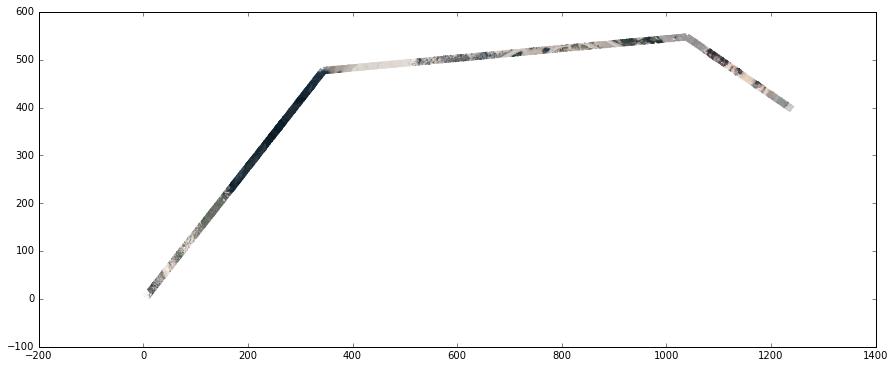

In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = len(lx)
x = lx
y = ly
colors = lc

plt.figure(figsize=(15, 6))
plt.scatter(x, y, s=1, c=colors, edgecolors='none')
plt.show()

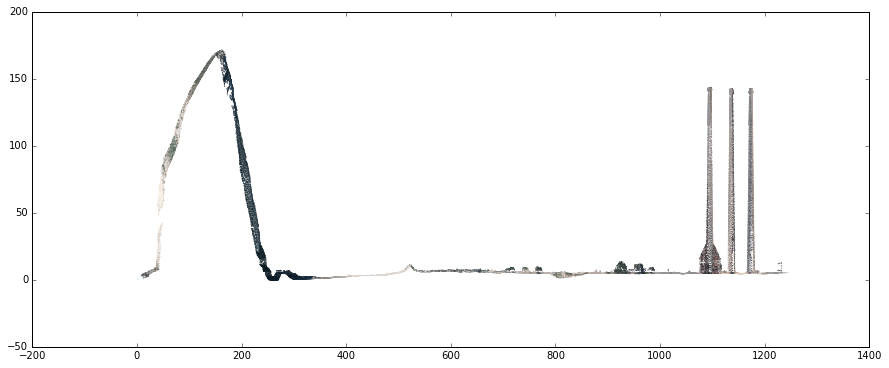

In [155]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


N = len(lx)
x = lx
y = lz
colors = lc

plt.figure(figsize=(15, 6))
plt.scatter(x, y, s=1, c=colors, edgecolors='none')
plt.show()